In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit
import geopandas as gpd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
plt.rcParams['font.family'] = 'Helvetica Light' #comment in case not installed
plt.rc('axes', unicode_minus=False)

import sys
sys.path.append('../d03_src/')
import vars
import process_graph
import process_demographics
import evaluate_utils as ev
import evaluate_equity as eq
import evaluate_visualization as vis
from utils import param_name, add_psi

np.random.seed(13)

# Visualization of Inference Results

In this notebook we go through results for real inference on 311 data, producing the plots on the paper.

## 0. Setting Parameters

### Priors

The prior I am using on $\theta$ is

$$ \theta_0 \sim \mathcal{N}\left(0.0, 0.50\right)$$
$$ \theta_1 \sim \mathcal{N}\left(0.1, 0.03\right)$$

For the case where the report rate $\psi$ is homogenous, I am using a Beta prior:

$$\psi \sim \text{Beta}\left(\text{mean}=0.6, \text{strength}=2\right)$$

For the case where the report rate $\psi$ is dependent on demographics, I am using the following covariates:

\begin{align*}
X_1 &:= \log(\text{population})\\
X_2 &:= \text{median income}\\
X_3 &:= \text{population with at least a bachelor degree }(\%)\\
X_4 &:= \text{non-hispanic population identifying as white alone }(\%)\\
X_5 &:= \text{median age}\\
X_6 &:= \text{households occupied by renter }(\%)
\end{align*}

All covariates are standardized. The reporting rate of census tract $i$ is a logistic linear combination of the form:

$$ \psi_i = \text{logit}^{-1}\left(\alpha_0 + \sum_{k=1}^6\alpha_k\cdot X_{ki}\right)$$

The priors used for the regression coefficients are:

$$\alpha_0 \sim \mathcal{N}\left(0, 1.0\right)$$
$$\alpha_1,\dots \alpha_6 \sim \mathcal{N}\left(0, 0.5\right)$$

### Graph

We use the census tract graph on the main text results and include the geohash graph on the SI

In [2]:
gdf_census, graph_census = process_graph.generate_graph_census(remove_zeropop=True, tresh_population=100,
                                                               remove_parks=True, tresh_parkarea=3/4,
                                                               remove_water=True)

gdf_hash, graph_hash = process_graph.generate_graph_geohash(precision=6,
                                                            remove_zeropop=True, tresh_population=100,
                                                            remove_parks=True, tresh_parkarea=3/4,
                                                            remove_water=True, tresh_water=1/3)

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 5 islands with ids: 70, 150, 869, 1120, 1530.
  warnings.warn(message)
/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


We need to collect the standardized, multivariate covariates for computing reporting rates:

In [3]:
features_census = process_demographics.include_covariates(gdf_census,
                                                          col_to_merge_on='GEOID',
                                                          processed_covariates_dir=vars._processed_covariates_dir,
                                                          covariates_names=vars._covariates,
                                                          standardize=True)

features_hash = process_demographics.include_covariates(gdf_hash,
                                                        col_to_merge_on='geohash',
                                                        processed_covariates_dir=vars._processed_covariates_dir,
                                                        covariates_names=vars._covariates,
                                                        standardize=True)

For plotting purposes, we also have the base NYC gdf:

In [4]:
nyc_boroughs = gpd.read_file('../d01_data/d01_raw/d02_spatial-data/NYC-boroughs/NYC-boroughs.shp')
nyc_boundary = gpd.GeoDataFrame(geometry=[nyc_boroughs.unary_union], crs=nyc_boroughs.crs).to_crs(gdf_census.crs)

### Processed Outputs:

In [5]:
output_dir = f'{vars._path_output_processed}inference/'

With the script `read_inference.py` we collected the following model outputs:

1. Posterior distributions for the full models in question (homogeneous and multivariate heterogeneous underreporting) in all three storms and both geographic units.
2. Node-level variables (probability of flood, reporting rate) according to the full models in question (homogeneous and multivariate heterogeneous underreporting) in all three storms and both geographic units.
3. Pooled posterior distributions for regression coefficients across multiple storms in the multivariate heterogeneous underreporting model and in univariate models for both geographic units.

In [6]:
summary_df = {}
for unit in ['census', 'geohash']:
    for storm in ['henri', 'ida', 'ophelia']:
        df = pd.read_csv(f'{output_dir}model-posteriors/summaries/{unit}-{storm}-multivariate.csv')
        summary_df[(unit, storm)] = df.set_index('Parameter')

pooled_df = {}
for unit in ['census', 'geohash']:
    for model in ['multivariates', 'univariates']:
        df = pd.read_csv(f'{output_dir}pooled-coefficients/{unit}-{model}.csv')
        pooled_df[(unit, model)] = df.set_index(['Model','Parameter'])

node_df = {}
for unit in ['census', 'geohash']:
    for storm in ['henri', 'ida', 'ophelia']:
        df = pd.read_csv(f'{output_dir}node-variables/{unit}-{storm}.csv')
        node_df[(unit, storm)] = df

### Models:

We will use the following convention for model names (both as written in the df and as human readable):

In [7]:
model_names = ['Heterogeneous Reporting', 'Homogeneous Reporting', 'GP Baseline', 'Spatial Baseline']
models = ['multivariate', 'homogeneous', 'GP', 'trivial']

## 1. Posterior Distributions and Multivariate Coefficients

We collect the posteriors for the multivariate models (the ones we believe represent the real data generating process). We show the posteriors for the three storms on the same axes:

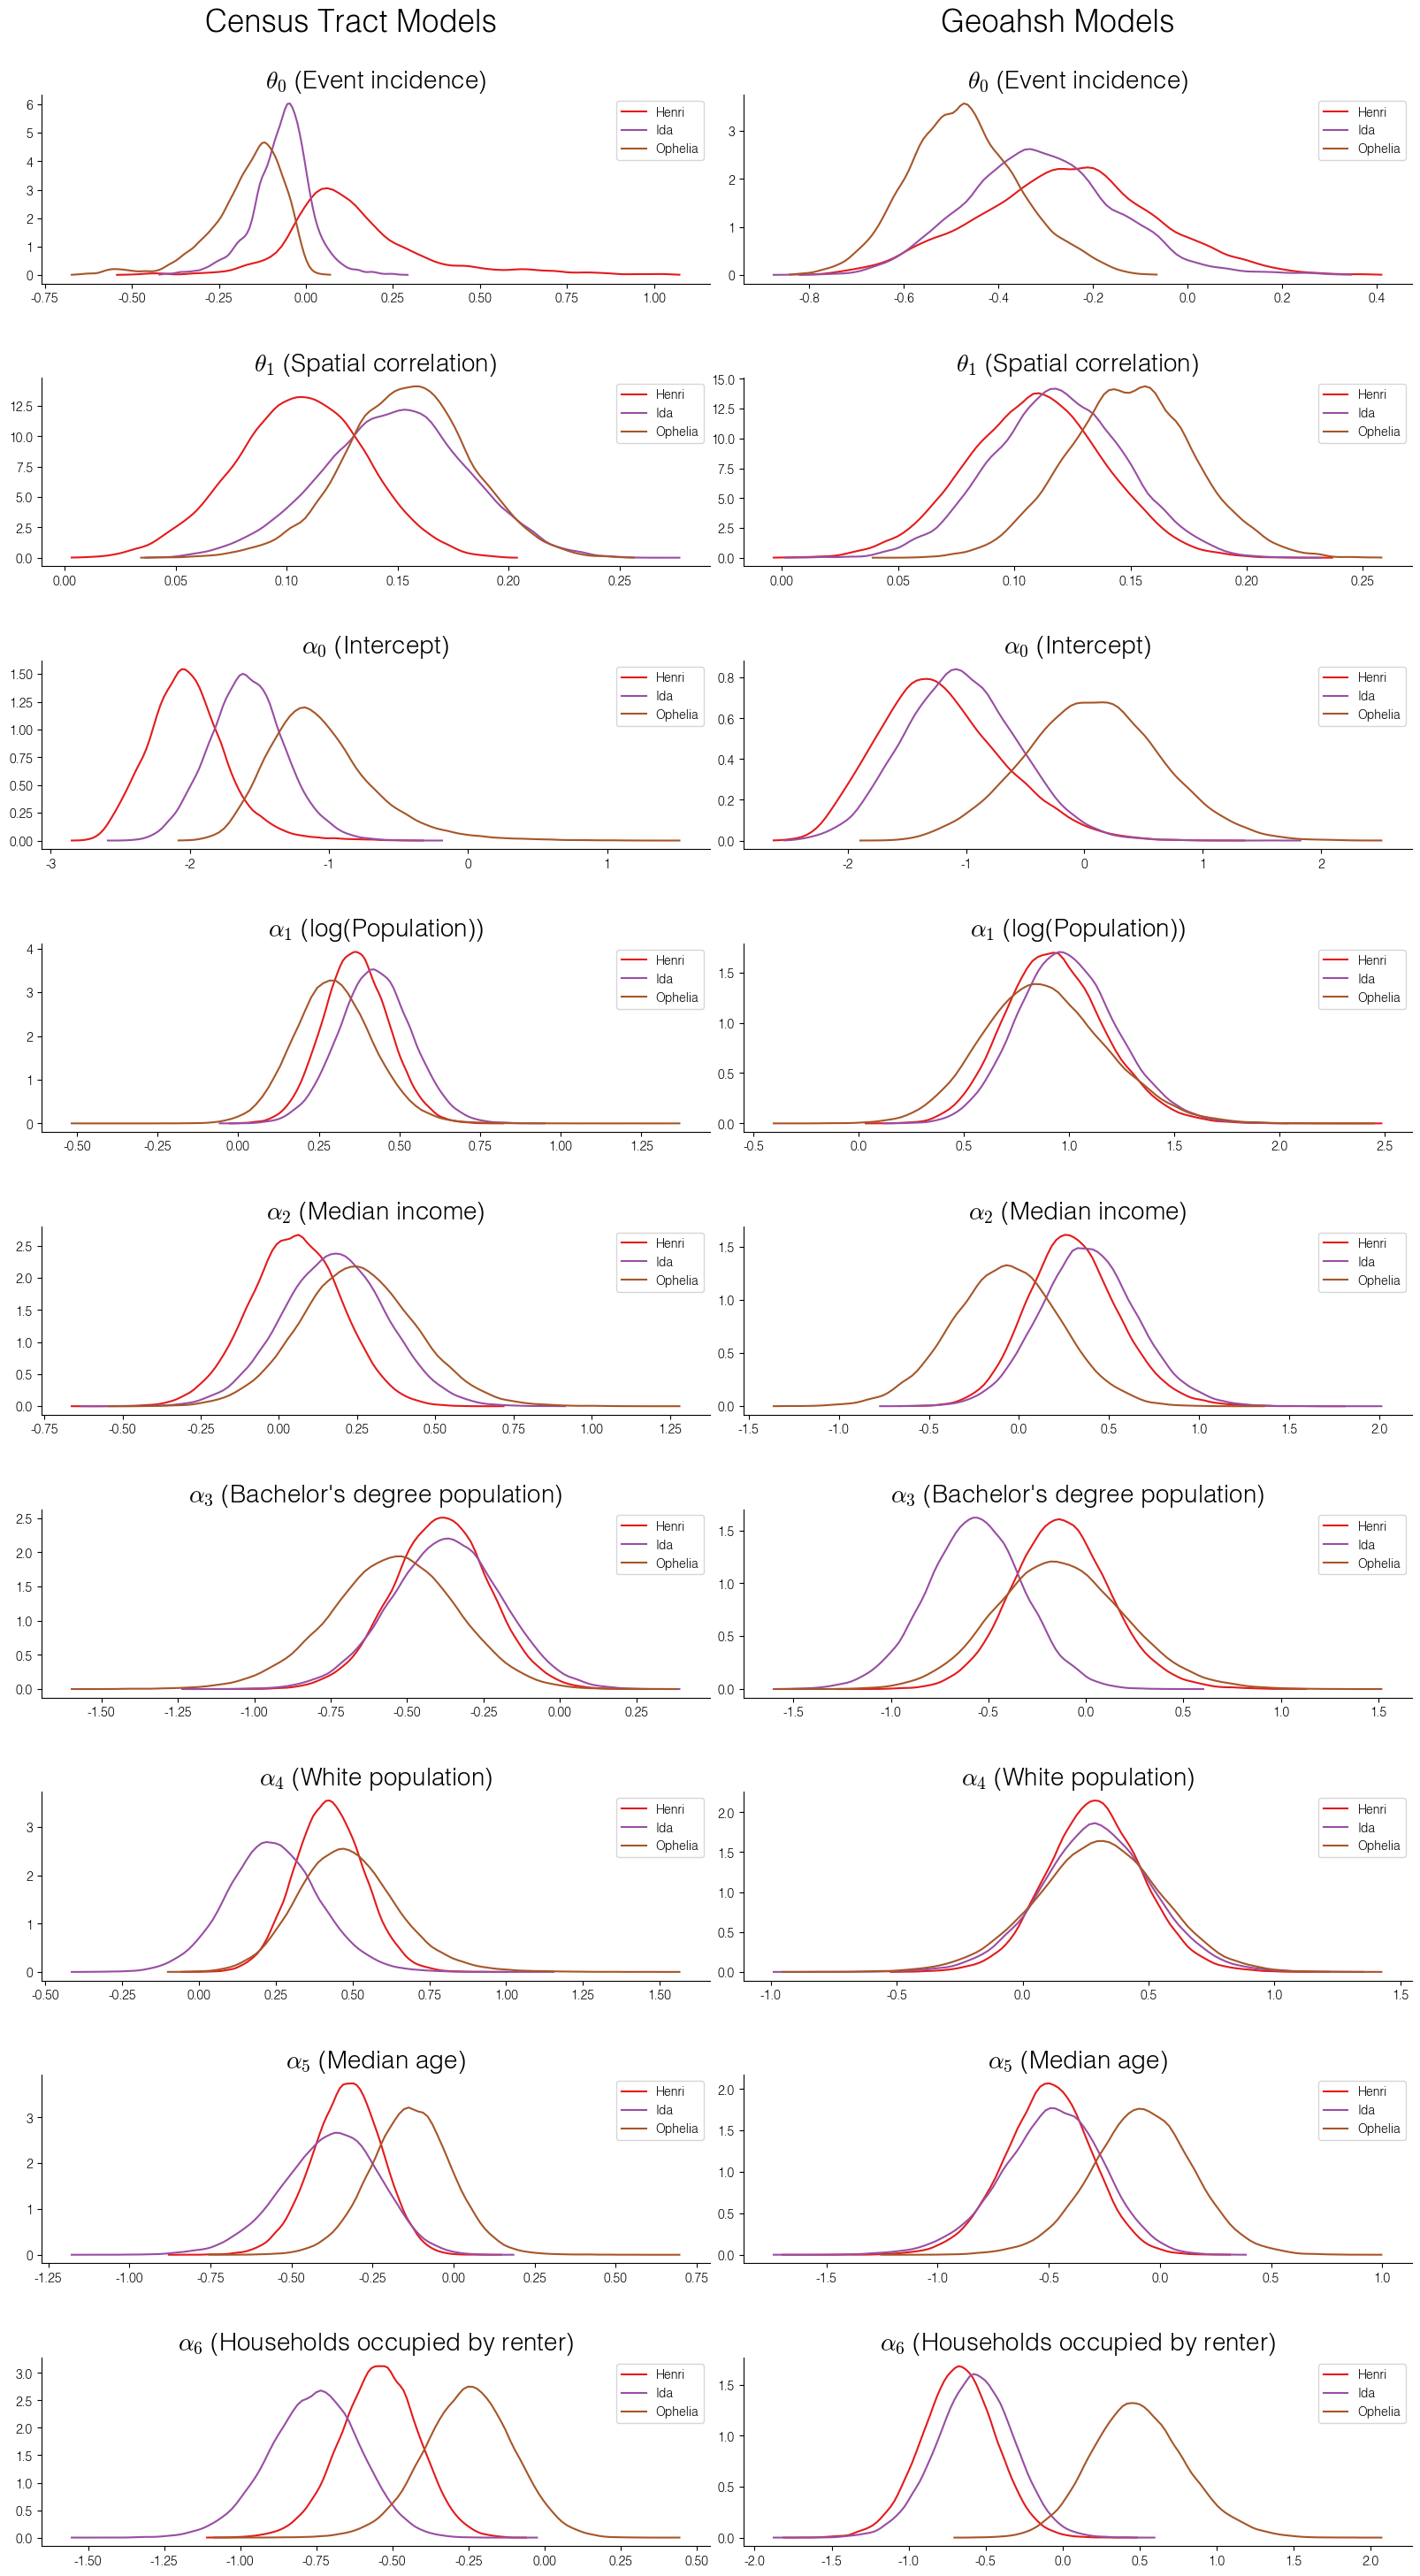

In [8]:
fig, Axes = plt.subplots(figsize=(20, 4*9), ncols=2, nrows=9)
parameters_to_plot = [f'theta{k}' for k in range(2)]+[f'alpha{k}' for k in range(7)]

for unit_idx, unit in enumerate(['census', 'geohash']):
    
    for storm_idx, storm in enumerate(['henri', 'ida', 'ophelia']):
        #Collect the corresponding posterior df:
        posteriors_df = pd.read_csv(f'{output_dir}model-posteriors/{unit}-{storm}-multivariate.csv')
        
        #Plot every parameter on one row:
        for param_idx, parameter in enumerate(parameters_to_plot):

            #Collect axis and values:
            ax = Axes[param_idx, unit_idx]
            values = posteriors_df[parameter].values

            #Do a kde and plot:
            kde = stats.gaussian_kde(values)
            x = np.linspace(min(values), max(values), 100)
            _ = ax.plot(x, kde(x), label=storm.capitalize(), color=cm['Set1'](storm_idx/3))

            #Configure the axis:
            _ = ax.spines[['right', 'top']].set_visible(False)
            param_latex_string = f'{parameter[:-1]}_{parameter[-1]}'
            _ = ax.set_title(fr'$\{param_latex_string}$' + f' ({vars._param_description[parameter]})', fontsize=20)
            _ = ax.legend()

_ = plt.subplots_adjust(wspace=0.05, hspace=0.5)
_ = plt.figtext(0.3, 0.9, 'Census Tract Models', fontsize=25 , ha='center')
_ = plt.figtext(0.7, 0.9, 'Geoahsh Models', fontsize=25, ha='center')

Main text results of estimates:

In [9]:
round(summary_df[('census', 'ida')][['mean', '2.5%', '97.5%', 'r_hat']],3)

mean   2.5%  97.5%  r_hat
Parameter                            
alpha0    -1.584 -2.104 -1.019  1.020
alpha1     0.426  0.204  0.652  1.000
alpha2     0.178 -0.152  0.509  1.000
alpha3    -0.373 -0.733 -0.021  1.000
alpha4     0.243 -0.049  0.552  1.001
alpha5    -0.381 -0.694 -0.109  1.003
alpha6    -0.758 -1.067 -0.474  1.002
theta0    -0.068 -0.256  0.093  1.025
theta1     0.149  0.083  0.211  1.003

We can also visualize the multivariate model coefficients:

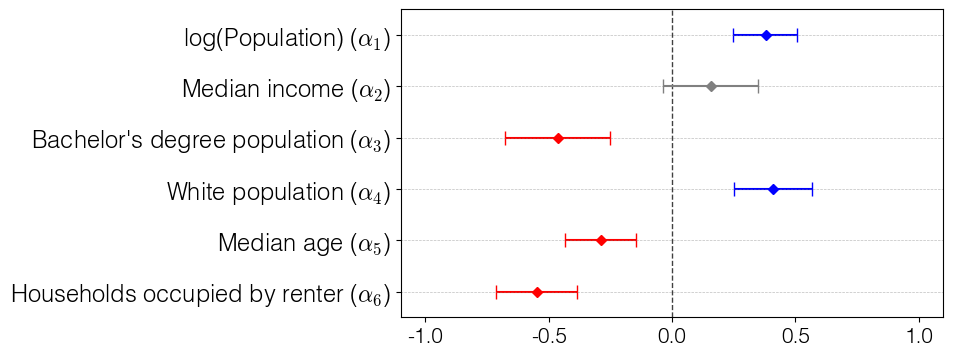

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))
CI_df = pooled_df[('census', 'multivariates')].loc['pooled'].rename({'mean':'Estimate', '2.5%':'Lower bound', '97.5%':'Upper bound'},axis=1)

#Plot on the corresponding axis:
ax = vis.plot_CIs_covariates(CI_df[['Estimate', 'Lower bound', 'Upper bound']],
                             show=False, ax=ax, ylabel_size=17, xlabel_size=15)
_ = ax.set_yticks(ax.get_yticks()[::-1], [param_name(parameter.split('_')[-1]) for parameter in list(CI_df.index)])
_ = ax.set_xlim(-1.1, 1.1)
fig.savefig('../d07_plots/MAIN_multivariate_coeffs_census_pooled.pdf', pad_inches=0.1, bbox_inches='tight', format='pdf')

## 2. Flood Prediction Analysis

Main text plots will be made for Ida in the census routine. Feel free to change the storm and unit:

In [11]:
df = node_df[('census', 'ida')]

Plot the multivariate model predicitons:

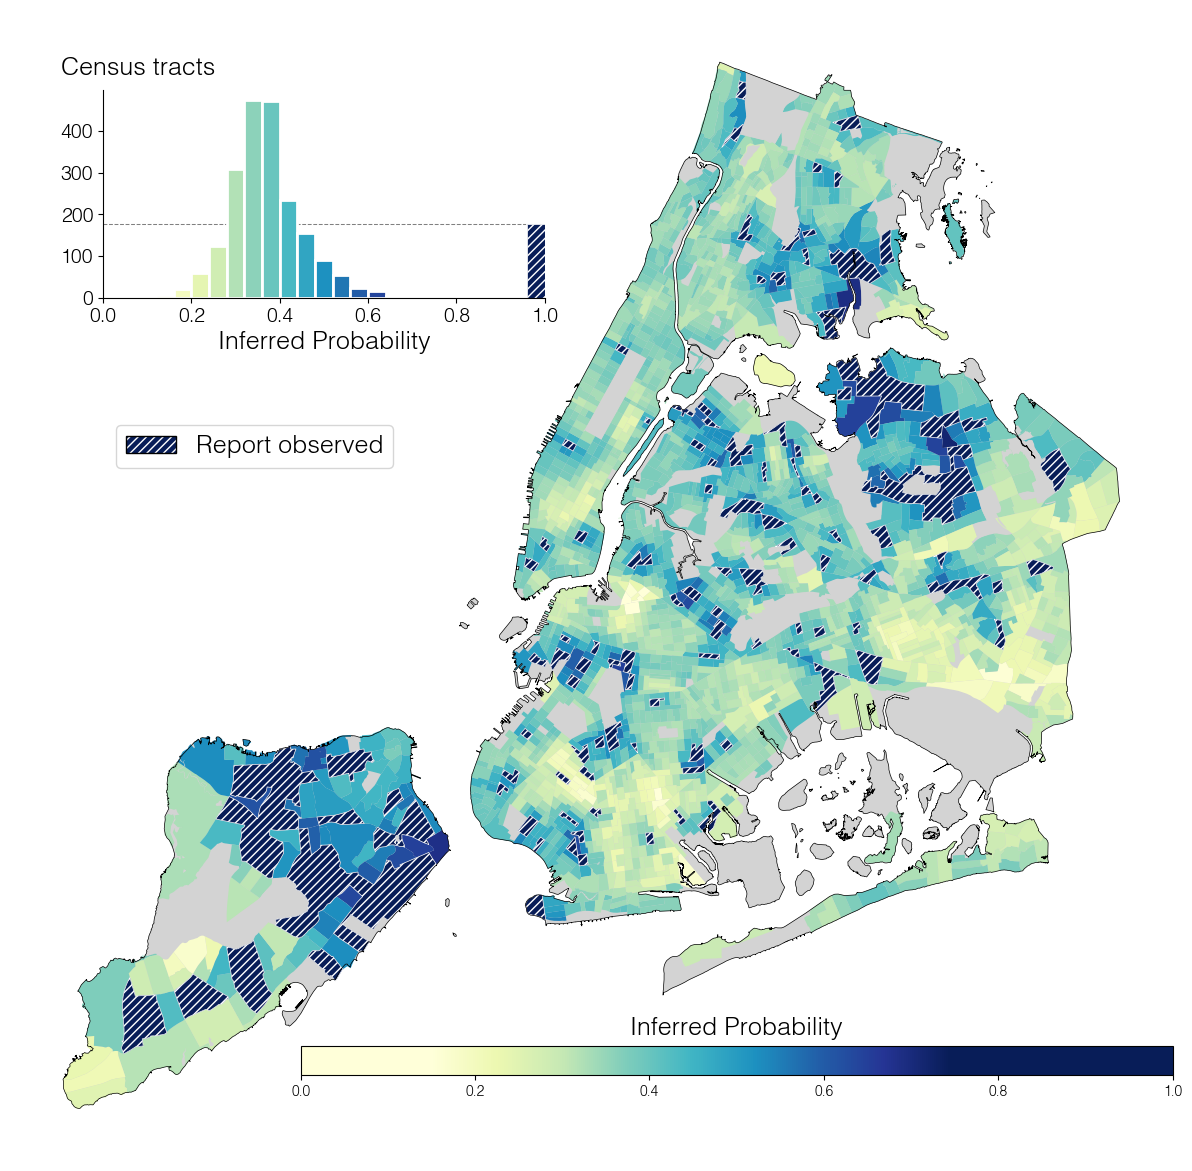

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
_ = vis.map(df['A_prob_multivariate'].values,
            gdf=gdf_census, #if unit=='census' else gdf_hash,
            base_gdf=nyc_boundary,
            hist_plot=True,
            special_hatch=True,
            special_line=True,
            legend_nodata=False,
            cmap_cropvalue_min=0.2,   #those are good bounds for Ida (main text)
            cmap_cropvalue=0.7,       #those are good bounds for Ida (main text)
            save=False,
            title=None,#f'Flood Predictions during {storm.capitalize()}',
            hist_ylabelsize=18,
            hist_xlabelsize=18,
            ticks_size=14,
            ax=ax,
            show=False)
fig.savefig('../d07_plots/MAIN_flood_probability_ida.pdf', pad_inches=0.1, bbox_inches='tight', format='pdf')
plt.show()

### 3. Model Performance

We collect two dataframes:

In [13]:
for storm in ['henri', 'ida', 'ophelia']:
    
    print('\n', storm.capitalize())
    scores = node_df[('census', storm)][[f'T_prob_{model}' for model in models]].values
    classes = node_df[('census', storm)]['T_test'].values
    performance_df, improvement_df = ev.evaluate_performance(scores,
                                                             classes,
                                                             metrics=['AUC', 'RMSE'],
                                                             confidence_level=0.95,
                                                             n_bootstrap=10_000,
                                                             return_improvement=True,
                                                             all_pairs=False,
                                                             model_names=model_names,
                                                             pval_method='two-sided')
    display(round(performance_df,3))
    display(round(improvement_df,3))


 Henri


AUC                   RMSE              
                        Estimate     LB     UB Estimate     LB     UB
Heterogeneous Reporting    0.730  0.658  0.798    0.171  0.156  0.186
Homogeneous Reporting      0.694  0.614  0.772    0.170  0.154  0.185
GP Baseline                0.638  0.557  0.718    0.347  0.330  0.364
Spatial Baseline           0.690  0.615  0.763    0.326  0.308  0.343

AUC                        \
                                              Estimate     LB     UB p-value   
Model A                 Model B                                                
Heterogeneous Reporting Homogeneous Reporting    0.036 -0.027  0.097   0.259   
                        GP Baseline              0.093  0.005  0.183   0.036   
                        Spatial Baseline         0.040 -0.031  0.112   0.261   
Homogeneous Reporting   GP Baseline              0.057 -0.008  0.125   0.085   
                        Spatial Baseline         0.004 -0.027  0.037   0.787   
GP Baseline             Spatial Baseline        -0.052 -0.111  0.004   0.067   

                                                  RMSE                        
                                              Estimate     LB     UB p-value  
Model A                 Model B                                               
Heterogeneous Reporting Homogeneous Reporting    0.002 -0.002  0.006   0.443  
                        GP Baseline             -0.176 -0.193 -0.158   0.000  
                        Spatial Baseline        -0.155 -0.172 -0.136   0.000  
Homogeneous Reporting   GP Baseline             -0.177 -0.196 -0.159   0.000  
                        Spatial Baseline        -0.156 -0.175 -0.137   0.000  
GP Baseline             Spatial Baseline         0.021  0.014  0.028   0.000


 Ida


AUC                   RMSE              
                        Estimate     LB     UB Estimate     LB     UB
Heterogeneous Reporting    0.680  0.646  0.713    0.355  0.338  0.371
Homogeneous Reporting      0.682  0.649  0.714    0.360  0.343  0.376
GP Baseline                0.629  0.595  0.662    0.417  0.400  0.434
Spatial Baseline           0.647  0.616  0.678    0.395  0.377  0.412

AUC                        \
                                              Estimate     LB     UB p-value   
Model A                 Model B                                                
Heterogeneous Reporting Homogeneous Reporting   -0.003 -0.028  0.022   0.831   
                        GP Baseline              0.051  0.019  0.084   0.003   
                        Spatial Baseline         0.032  0.008  0.057   0.009   
Homogeneous Reporting   GP Baseline              0.053  0.027  0.080   0.000   
                        Spatial Baseline         0.035  0.017  0.053   0.000   
GP Baseline             Spatial Baseline        -0.018 -0.042  0.006   0.130   

                                                  RMSE                        
                                              Estimate     LB     UB p-value  
Model A                 Model B                                               
Heterogeneous Reporting Homogeneous Reporting   -0.004 -0.007 -0.001   0.004  
                        GP Baseline             -0.062 -0.075 -0.049   0.000  
                        Spatial Baseline        -0.040 -0.052 -0.027   0.000  
Homogeneous Reporting   GP Baseline             -0.058 -0.072 -0.044   0.000  
                        Spatial Baseline        -0.035 -0.049 -0.022   0.000  
GP Baseline             Spatial Baseline         0.023  0.016  0.030   0.000


 Ophelia


AUC                   RMSE              
                        Estimate     LB     UB Estimate     LB     UB
Heterogeneous Reporting    0.716  0.682  0.750    0.322  0.305  0.339
Homogeneous Reporting      0.706  0.671  0.739    0.323  0.306  0.339
GP Baseline                0.640  0.603  0.676    0.400  0.382  0.417
Spatial Baseline           0.671  0.637  0.704    0.372  0.354  0.390

AUC                        \
                                              Estimate     LB     UB p-value   
Model A                 Model B                                                
Heterogeneous Reporting Homogeneous Reporting    0.011 -0.006  0.026   0.207   
                        GP Baseline              0.076  0.044  0.108   0.000   
                        Spatial Baseline         0.045  0.023  0.067   0.000   
Homogeneous Reporting   GP Baseline              0.066  0.039  0.093   0.000   
                        Spatial Baseline         0.035  0.017  0.053   0.000   
GP Baseline             Spatial Baseline        -0.031 -0.055 -0.008   0.009   

                                                  RMSE                        
                                              Estimate     LB     UB p-value  
Model A                 Model B                                               
Heterogeneous Reporting Homogeneous Reporting   -0.001 -0.003  0.002   0.606  
                        GP Baseline             -0.078 -0.091 -0.064   0.000  
                        Spatial Baseline        -0.050 -0.063 -0.037   0.000  
Homogeneous Reporting   GP Baseline             -0.077 -0.091 -0.063   0.000  
                        Spatial Baseline        -0.049 -0.063 -0.036   0.000  
GP Baseline             Spatial Baseline         0.028  0.021  0.034   0.000

### 4. Reporting Rate

Let's report the rate per group:

In [14]:
estimates = pooled_df[('census', 'multivariates')].loc['pooled', 'mean'].values
inf_psi_values = expit(np.sum(estimates*features_census, axis=1))

group_labels=['white','black', 'hispanic', 'asian']
group_weights=df[[f'population_{race}' for race in group_labels]].values
bar_dict_w = {group: np.average(inf_psi_values, weights=group_weights[:,k]) for k, group in enumerate(group_labels)}

print(f'{group_labels[0].capitalize()} population reports floods on average:')
for group in group_labels[1:]:
    print(f"* {bar_dict_w[group_labels[0]]/bar_dict_w[group]-1:.2%} more than {group} population")
    
print('\nRelative to the city average report rate:')
city_avg = np.average(inf_psi_values, weights=df['population'].values)
for group in group_labels:
    overreport = bar_dict_w[group]/city_avg-1
    print(f"* {group.capitalize()} population reports {abs(overreport):.2%} {'less' if overreport<0 else 'more'}")
print('\n')

print(f'\nThe report rates range from {inf_psi_values.min():.2f} to {inf_psi_values.max():.2f}')

White population reports floods on average:
* 23.70% more than black population
* 17.98% more than hispanic population
* 11.99% more than asian population

Relative to the city average report rate:
* White population reports 11.56% more
* Black population reports 9.82% less
* Hispanic population reports 5.45% less
* Asian population reports 0.38% less



The report rates range from 0.03 to 0.93


We visualize the report rate map as follows:

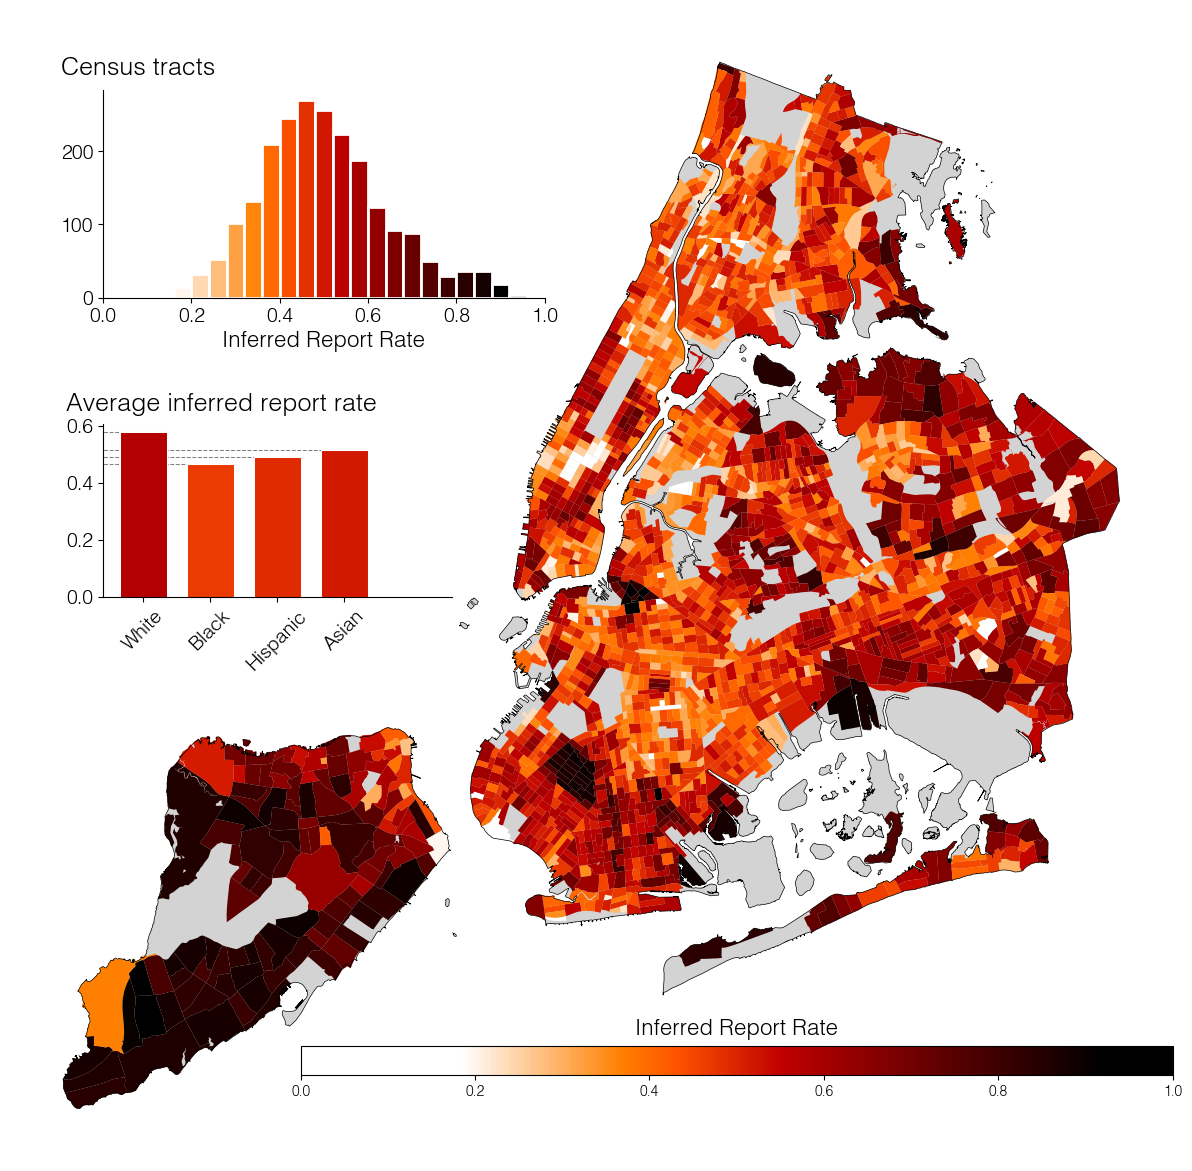

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = vis.map(inf_psi_values,
            gdf=gdf_census,
            base_gdf=nyc_boundary,
            values_name='Inferred Report Rate',
            special_class=False,
            title=None,
            cmap_cropvalue_min=.2,
            cmap_cropvalue=.9, cmap_name='gist_heat_r',
            hist_plot=True, hist_orientation='vertical',
            bar_plot=True,
            legend_nodata=False,
            psibar_weights=group_weights,
            save=False,
            show=False,
            ax=ax,
            hist_ylabelsize=18,
            hist_xlabelsize=16,
            ticks_size=14,
            psibar_ylabelsize=18,
            psibar_xlabelsize=18)
fig.savefig('../d07_plots/MAIN_report_probability_pooled.pdf', pad_inches=0.1, bbox_inches='tight', format='pdf')
plt.show()

### 5. Equity Analysis

For the equity analysis let's read the counts corresponding to each of the multivariate coefficients:

In [16]:
#For race, income, education, and home ownership groups we use percents:
race_counts = np.vstack([df['population_white'].values, df[[f'population_{x}' for x in ['black', 'hispanic', 'asian']]].sum(axis=1).values]).T
income_counts = np.vstack([df.population.values - df.population_poverty.values, df.population_poverty.values]).T
education_counts = np.vstack([df.population.values - df.population_nohighschool.values, df.population_nohighschool.values]).T
renter_counts = np.vstack([df.population.values - df.population_renter.values, df.population_renter.values]).T

#Collect the scores and reports:
scores = df[[f'A_prob_{model}' for model in models[::-1]]].values
training_reports = df['T_train'].values

#Assign colors:
cmap = cm.get_cmap('YlGnBu')
colors = ['grey', cmap(0.3), cmap(0.6), cmap(1.)]

#Fix capacity:
capacity=100

On the main text, we report only two plots:

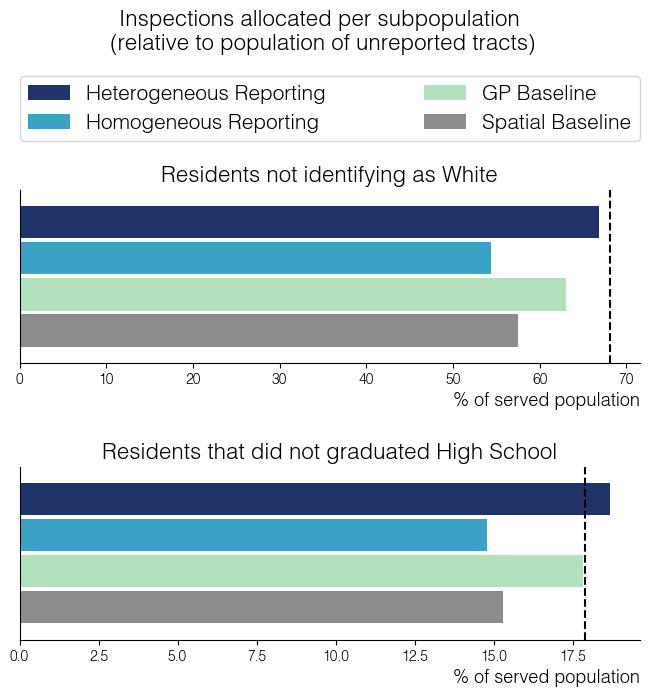

In [17]:
fig, Ax = plt.subplots(figsize=(8, 4.5), nrows=2)
plt.subplots_adjust(top = 1., bottom=0, hspace=0.6)

for ax, ct, names in zip(Ax,
                         [race_counts, education_counts],
                         [['White', 'Residents not identifying as White'],
                          ['Graduated High School', 'Residents that did not graduated High School']]):
 
    ax = eq.plot_weighted_equity(scores,
                                 training_reports,
                                 capacity=100,
                                 colors=colors,
                                 model_names=model_names[::-1],
                                 node_weights=ct,
                                 node_weights_names=names,
                                 relative_to_baseline=False,
                                 plot_baselines=True,
                                 groups_to_plot=[names[-1]],
                                 xticks=True,
                                 xrange=None,
                                 xlabel='% of served population',
                                 xlabel_size=13,
                                 legend=False,
                                 title=names[-1],
                                 ax=ax)
#Add a legend:
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles[::-1],
              labels[::-1],
              bbox_to_anchor = (0., 1.28, 1., .102),
              bbox_transform=Ax[0].transAxes,
              loc='lower left',
              fontsize=15,
              ncols=2,
              mode='expand',
              borderaxespad=0.)

_ = plt.suptitle('Inspections allocated per subpopulation\n (relative to population of unreported tracts)', fontsize=16, y=1.4)
fig.savefig('../d07_plots/MAIN_equity_barplot.pdf', pad_inches=0.1, bbox_inches='tight', format='pdf')

plt.show()

On the SI, we report all of the options (as well line plots for multiple k)

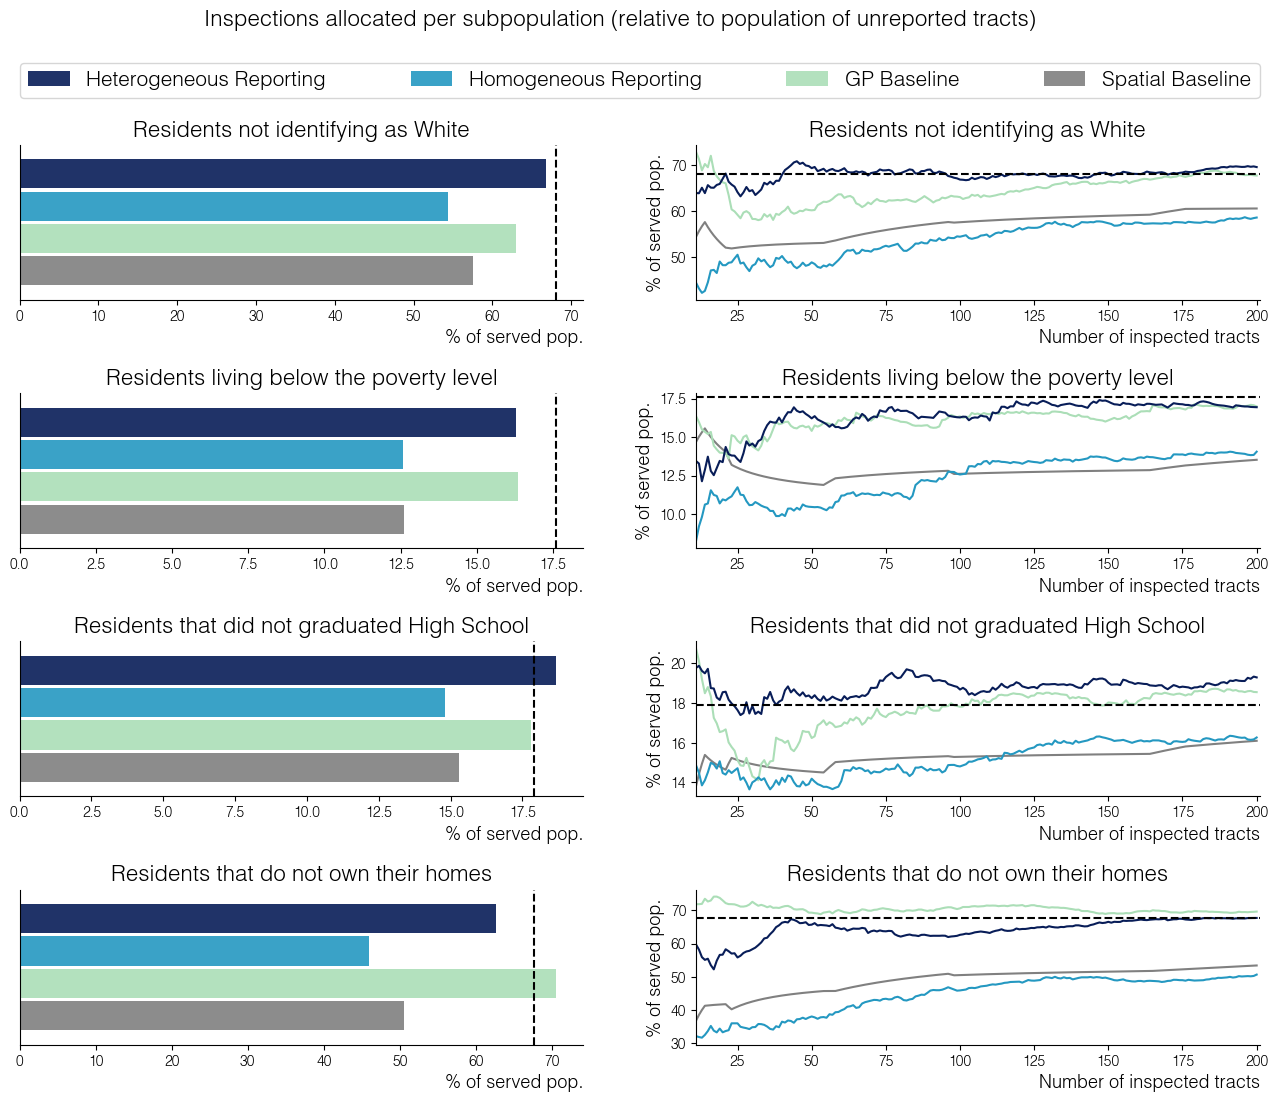

In [18]:
fig, Ax = plt.subplots(figsize=(16, 9), nrows=4, ncols=2)
plt.subplots_adjust(top = 1., bottom=0, hspace=0.6, wspace=0.2)

for Ax_row, ct, names in zip(Ax,
                             [race_counts, income_counts, education_counts, renter_counts],
                             [['White', 'Residents not identifying as White'],
                              ['High Income', 'Residents living below the poverty level'], 
                              ['Graduated High School', 'Residents that did not graduated High School'],
                              ['Owning Homes', 'Residents that do not own their homes']]):
    ax = Ax_row[0]
    ax = eq.plot_weighted_equity(scores,
                                 training_reports,
                                 capacity=100,
                                 colors=colors,
                                 model_names=model_names[::-1],
                                 node_weights=ct,
                                 node_weights_names=names,
                                 relative_to_baseline=False,
                                 plot_baselines=True,
                                 groups_to_plot=[names[-1]],
                                 xticks=True,
                                 xrange=None,
                                 xlabel='% of served pop.',
                                 xlabel_size=13,
                                 legend=False,
                                 title=names[-1],
                                 ax=ax)
    ax = Ax_row[1]
    ax = eq.plot_line_equity(scores,
                             training_reports,
                             capacities=(11,201),
                             colors=colors,
                             model_names=model_names[::-1],
                             node_weights=ct,
                             node_weights_names=names,
                             relative_to_baseline=False,
                             legend=False,
                             plot_baselines=True,
                             groups_to_plot=[names[-1]],
                             ylabel='% of served pop.',
                             title_size=16,
                             title=names[-1],
                             ax=ax)
#Add a legend:
handles, labels = Ax[0,0].get_legend_handles_labels()
_ = Ax[0,0].legend(handles[::-1],
                   labels[::-1],
                   bbox_to_anchor = (0., 1.3, 2.2, .2),
                   bbox_transform=Ax[0,0].transAxes,
                   loc='lower left',
                   fontsize=15,
                   ncols=4,
                   mode='expand',
                   borderaxespad=0.)

_ = plt.suptitle('Inspections allocated per subpopulation (relative to population of unreported tracts)', fontsize=16, y=1.15)
fig.savefig('../d07_plots/SI_equity.pdf', pad_inches=0.1, bbox_inches='tight', format='pdf')

plt.show()

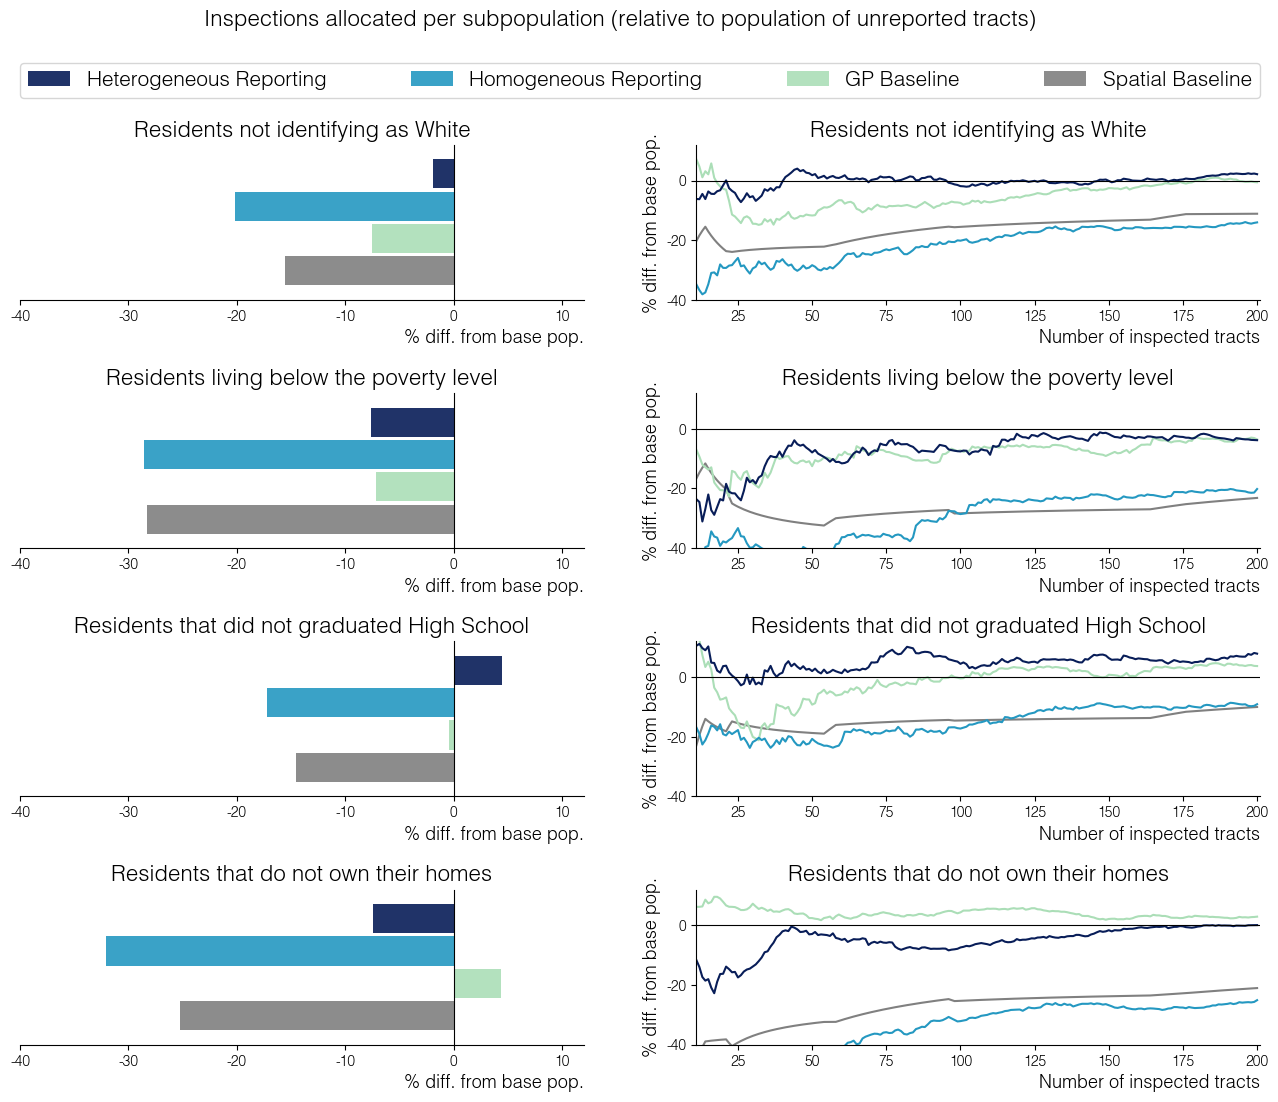

In [19]:
fig, Ax = plt.subplots(figsize=(16, 9), nrows=4, ncols=2)
plt.subplots_adjust(top = 1., bottom=0, hspace=0.6, wspace=0.2)

for Ax_row, ct, names in zip(Ax,
                             [race_counts, income_counts, education_counts, renter_counts],
                             [['White', 'Residents not identifying as White'],
                              ['High Income', 'Residents living below the poverty level'], 
                              ['Graduated High School', 'Residents that did not graduated High School'],
                              ['Owning Homes', 'Residents that do not own their homes']]):
    ax = Ax_row[0]
    ax = eq.plot_weighted_equity(scores,
                                 training_reports,
                                 capacity=100,
                                 colors=colors,
                                 model_names=model_names[::-1],
                                 node_weights=ct,
                                 node_weights_names=names,
                                 relative_to_baseline=True,
                                 groups_to_plot=[names[-1]],
                                 xticks=True,
                                 xrange=(-40, 12),
                                 xlabel='% diff. from base pop.',
                                 xlabel_size=13,
                                 legend=False,
                                 title=names[-1],
                                 ax=ax)
    ax = Ax_row[1]
    ax = eq.plot_line_equity(scores,
                             training_reports,
                             capacities=(11,201),
                             colors=colors,
                             model_names=model_names[::-1],
                             node_weights=ct,
                             node_weights_names=names,
                             relative_to_baseline=True,
                             legend=False,
                             groups_to_plot=[names[-1]],
                             ylabel='% diff. from base pop.',
                             title_size=16,
                             yrange=(-40, 12),
                             title=names[-1],
                             ax=ax)
#Add a legend:
handles, labels = Ax[0,0].get_legend_handles_labels()
_ = Ax[0,0].legend(handles[::-1],
                   labels[::-1],
                   bbox_to_anchor = (0., 1.3, 2.2, .2),
                   bbox_transform=Ax[0,0].transAxes,
                   loc='lower left',
                   fontsize=15,
                   ncols=4,
                   mode='expand',
                   borderaxespad=0.)

_ = plt.suptitle('Inspections allocated per subpopulation (relative to population of unreported tracts)', fontsize=16, y=1.15)
fig.savefig('../d07_plots/SI_equity_diff.pdf', pad_inches=0.1, bbox_inches='tight', format='pdf')

plt.show()

### SI: Multiple Storms

In [20]:
unit='census'

In the SI, we report results for multiple storms, starting with the multivariate model parameters:

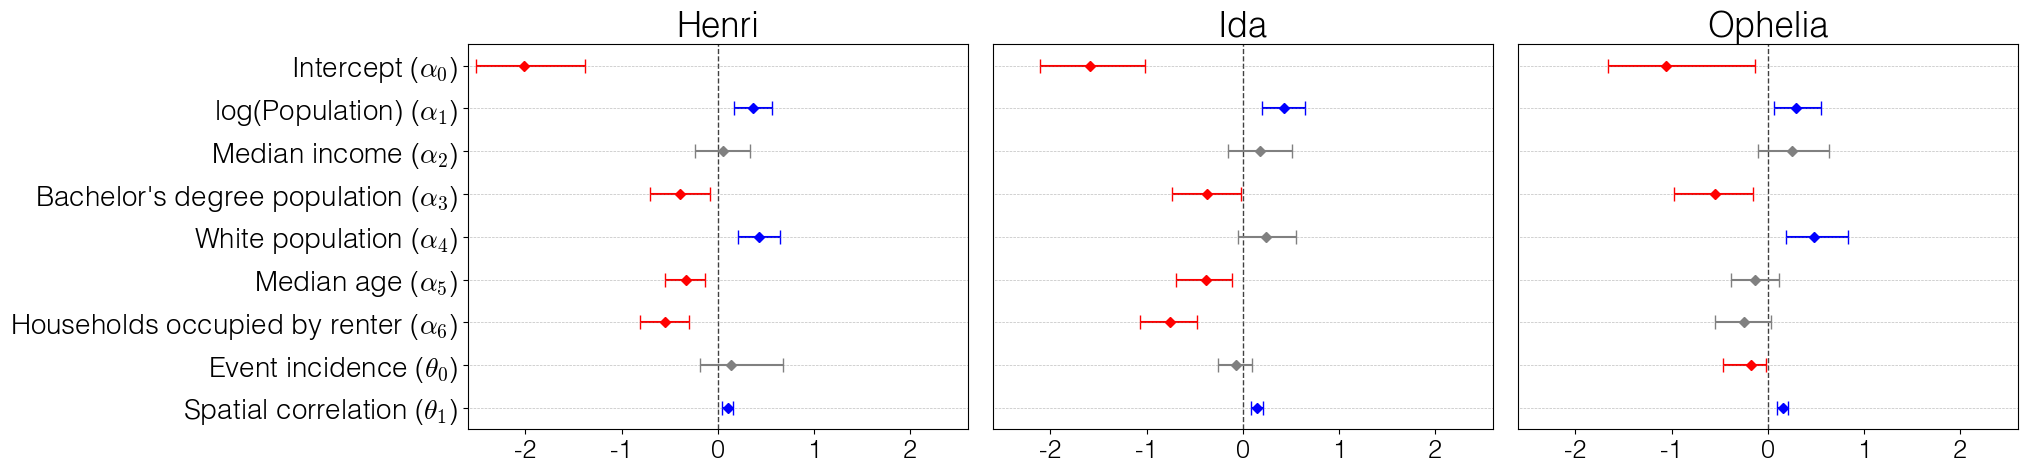

In [21]:
fig, Axes = plt.subplots(figsize=(20, 5), ncols=3)

for idx, storm in enumerate(['henri', 'ida', 'ophelia']):
    
    #Collect the corresponding summary df:
    CI_df = summary_df[(unit, storm)].rename({'mean':'Estimate', '2.5%':'Lower bound', '97.5%':'Upper bound'},axis=1)
    
    #Plot on the corresponding axis:
    Axes[idx] = vis.plot_CIs_covariates(CI_df[['Estimate', 'Lower bound', 'Upper bound']],
                                        show=False, ax=Axes[idx], ylabel_size=0, xlabel_size=18)

    #Configure the axis:
    _ = Axes[idx].set_title(storm.capitalize(), fontsize=25)
    if idx != 0: _ = Axes[idx].set_yticks([])
    if idx == 0: _ = Axes[idx].set_yticks(Axes[idx].get_yticks()[::-1],
                                          [param_name(parameter) for parameter in list(CI_df.index)],
                                          fontsize=20)
    _ = Axes[idx].set_xlim(-2.6, 2.6)
    
_ = plt.subplots_adjust(wspace=0.05)
fig.savefig(f'../d07_plots/SI_multivariate_coeffs_{unit}.pdf', pad_inches=0.3, bbox_inches='tight', format='pdf')
plt.show()

We also verify the correlation between inferred report rates $\psi_i$ per tract across all storms:

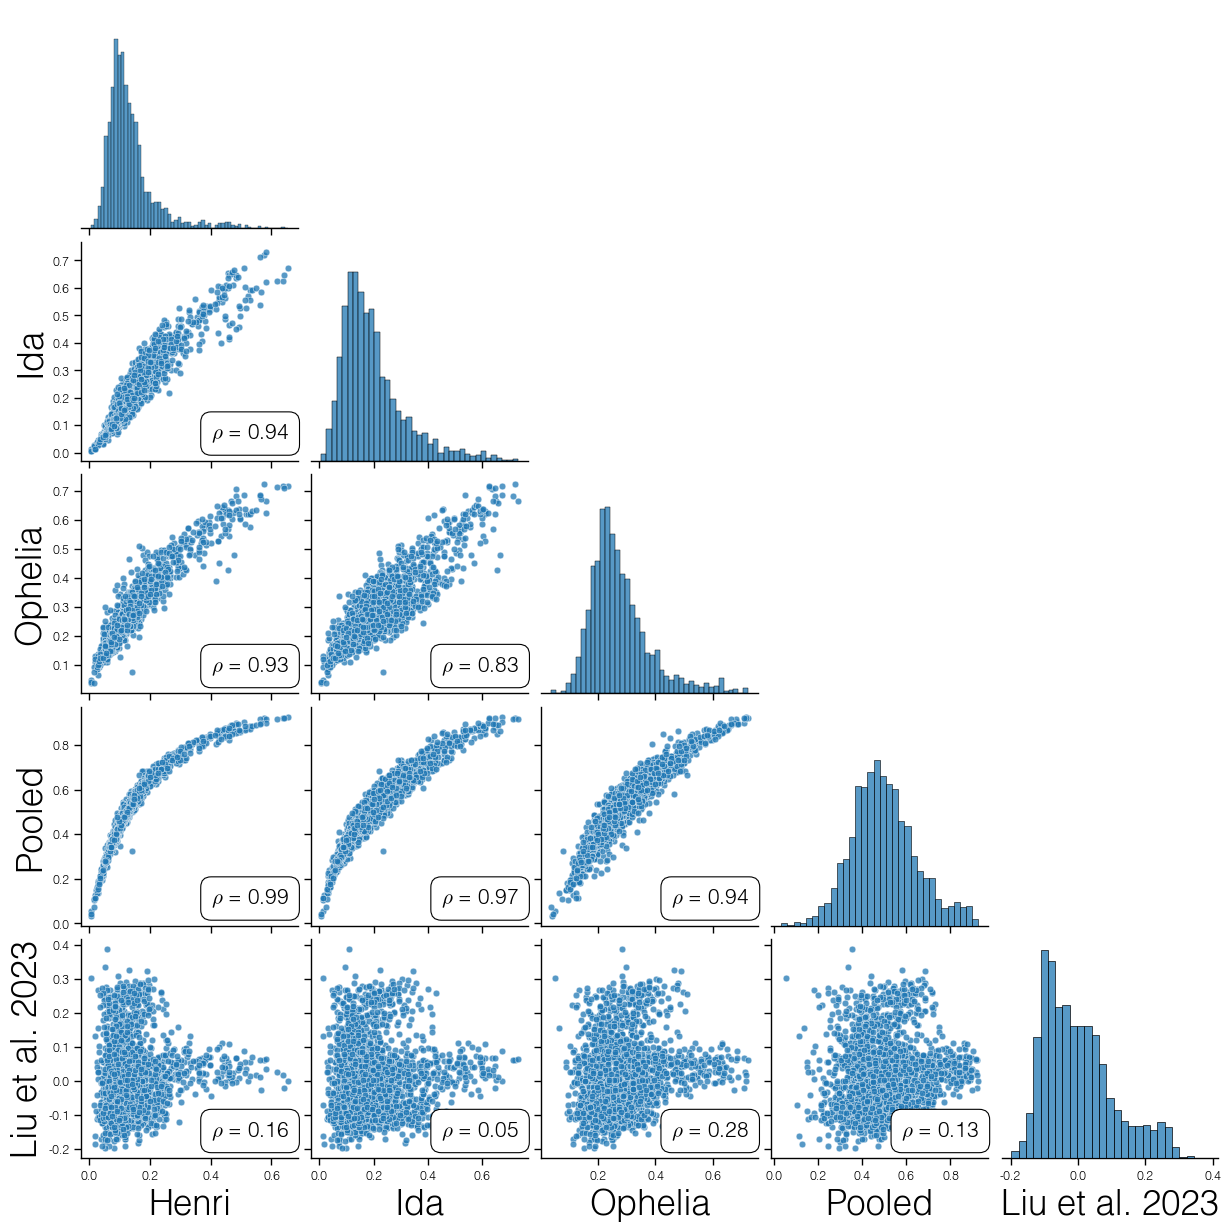

In [22]:
#We will correlated with the values from Liu et al. (data was provided to us by the authors):
liu_values = [process_demographics.include_liu(gdf_census.GEOID.values.astype(int))]
psi_values = [node_df[('census', storm)].psi_multivariate.to_list() for storm in ['henri', 'ida', 'ophelia']]    

#Pooled psi:
estimates = pooled_df[('census', 'multivariates')].loc['pooled', 'mean'].values
psi_values.append(expit(np.sum(estimates*features_census, axis=1)))

#Now we do a scatterplot of pairwise correlations:
graph = vis.correlation_pairlot(psi_values + liu_values,
                                value_names=['Henri', 'Ida', 'Ophelia', 'Pooled', 'Liu et al. 2023'],
                                plot_correlations=True,
                                correlation_fontsize=15,
                                label_fontsize=25,
                                alpha=0.75)

plt.savefig('../d07_plots/SI_correlation_census.pdf', bbox_inches='tight')
plt.show()

### SI: Geohash

In [23]:
unit='geohash'

In the SI, we report results for geohashes, starting with the multivariate model parameters:

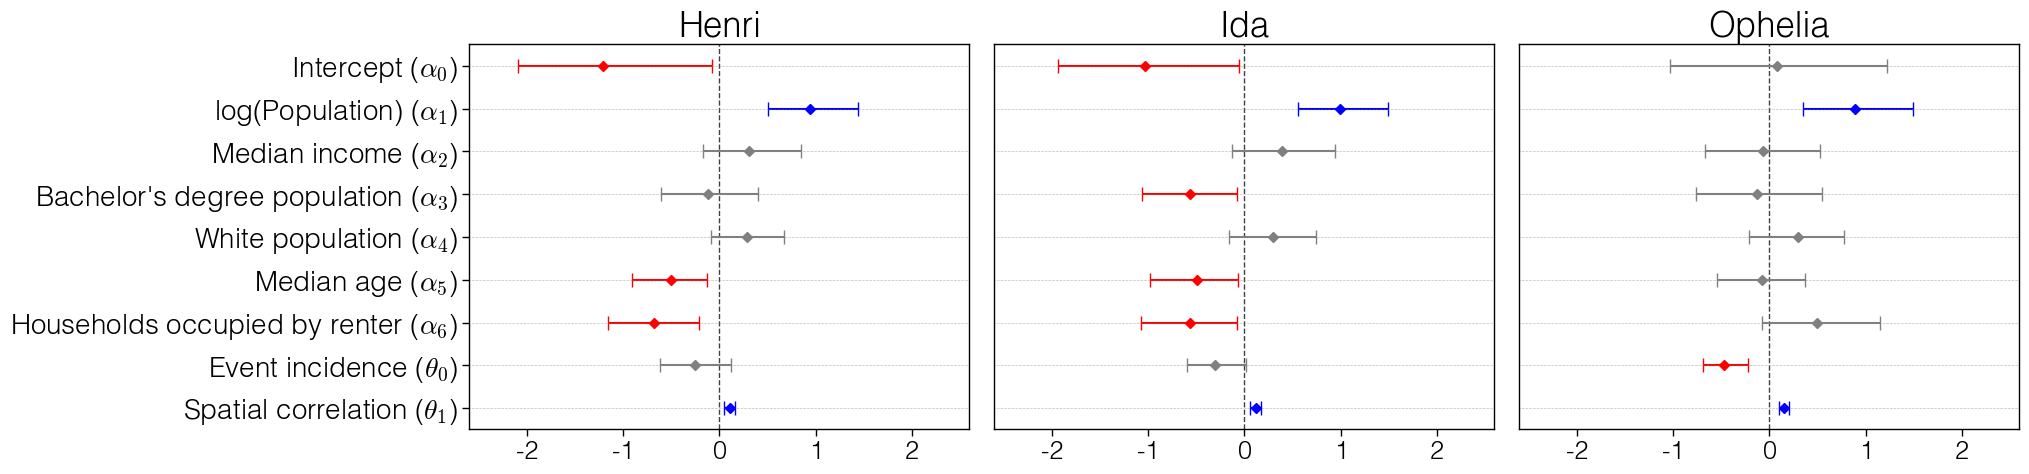

In [24]:
fig, Axes = plt.subplots(figsize=(20, 5), ncols=3)

for idx, storm in enumerate(['henri', 'ida', 'ophelia']):
    
    #Collect the corresponding summary df:
    CI_df = summary_df[('geohash', storm)].rename({'mean':'Estimate', '2.5%':'Lower bound', '97.5%':'Upper bound'},axis=1)
    
    #Plot on the corresponding axis:
    Axes[idx] = vis.plot_CIs_covariates(CI_df[['Estimate', 'Lower bound', 'Upper bound']],
                                        show=False, ax=Axes[idx], ylabel_size=0, xlabel_size=18)

    #Configure the axis:
    _ = Axes[idx].set_title(storm.capitalize(), fontsize=25)
    if idx != 0: _ = Axes[idx].set_yticks([])
    if idx == 0: _ = Axes[idx].set_yticks(Axes[idx].get_yticks()[::-1],
                                          [param_name(parameter) for parameter in list(CI_df.index)],
                                          fontsize=20)
    _ = Axes[idx].set_xlim(-2.6, 2.6)
    
_ = plt.subplots_adjust(wspace=0.05)
fig.savefig(f'../d07_plots/SI_multivariate_coeffs_{unit}.pdf', pad_inches=0.3, bbox_inches='tight', format='pdf')
plt.show()

We also verify the correlation between inferred report rates $\psi_i$ per geohash across all storms:

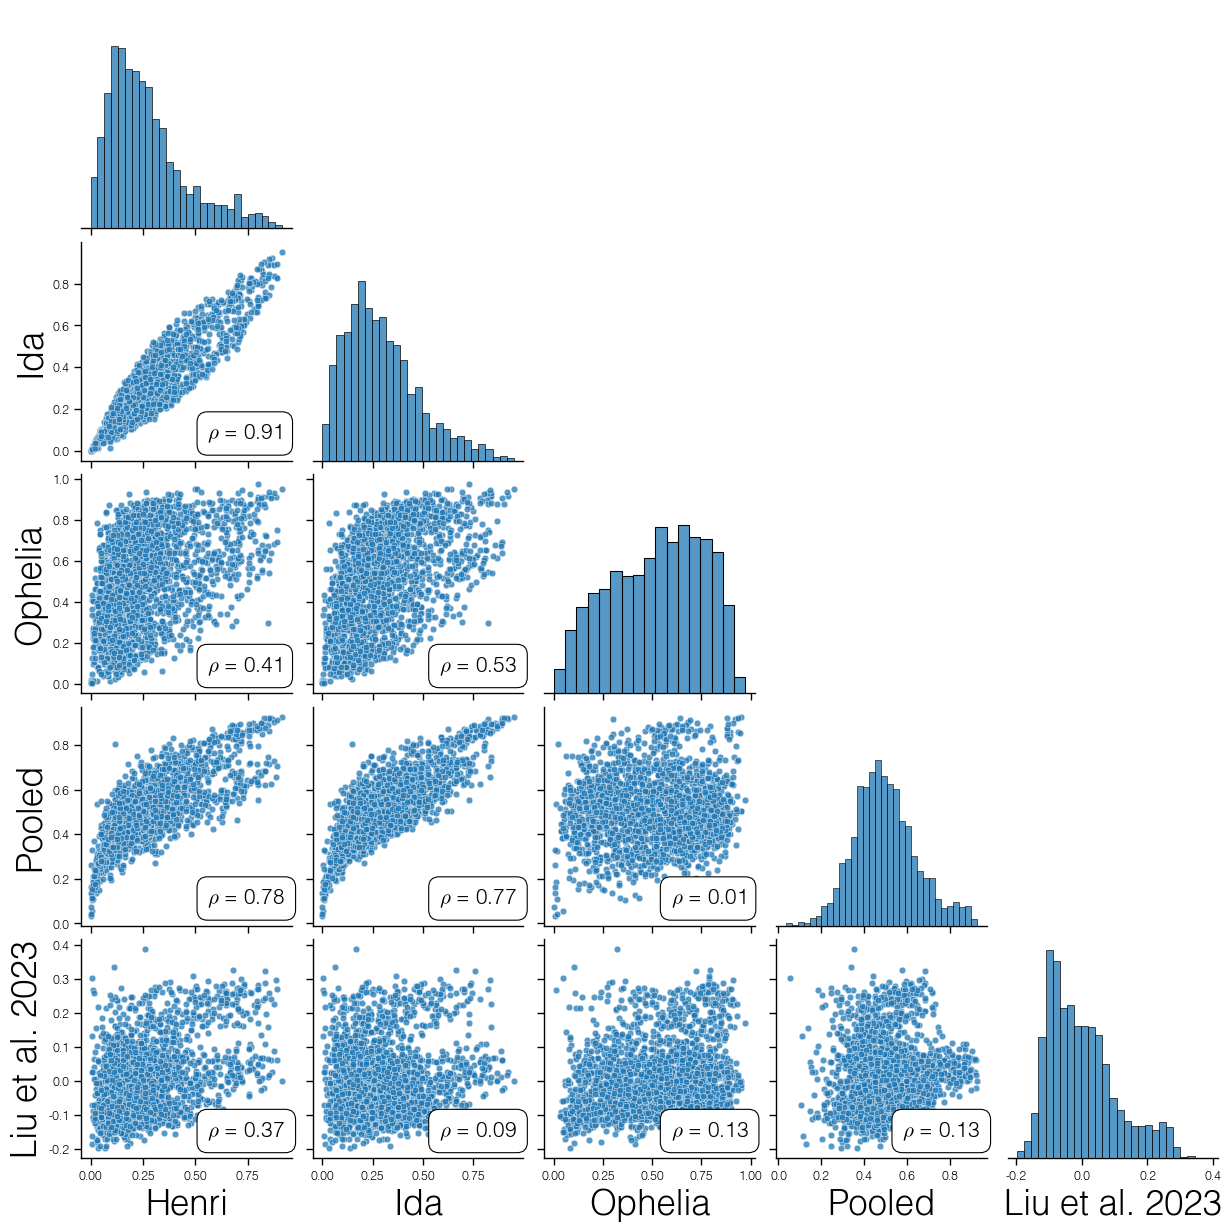

In [25]:
liu_values = [process_demographics.include_liu(gdf_census.GEOID.values.astype(int))]

#Since we are correlating this with Liu et al, we must project to census tracts:
psi_values = []
for storm in ['henri', 'ida', 'ophelia']:
    estimates = summary_df[('geohash', storm)].loc[[f'alpha{k}' for k in range(7)], 'mean'].values
    psi = expit(estimates[0] + np.sum(estimates[1:]*features_census, axis=1))
    psi_values.append(psi)

#Pooled psi:
estimates = pooled_df[('census', 'multivariates')].loc['pooled', 'mean'].values
psi_values.append(expit(np.sum(estimates*features_census, axis=1)))

#Now we do a scatterplot of pairwise correlations:
graph = vis.correlation_pairlot(psi_values+liu_values,
                                value_names=['Henri', 'Ida', 'Ophelia', 'Pooled', 'Liu et al. 2023'],
                                plot_correlations=True,
                                correlation_fontsize=15,
                                label_fontsize=25,
                                alpha=0.75)
            
plt.savefig('../d07_plots/SI_correlation_geohash.pdf', bbox_inches='tight')
plt.show()

To report the pooled multivariate coefficients, side-by-side with the census coefficients:

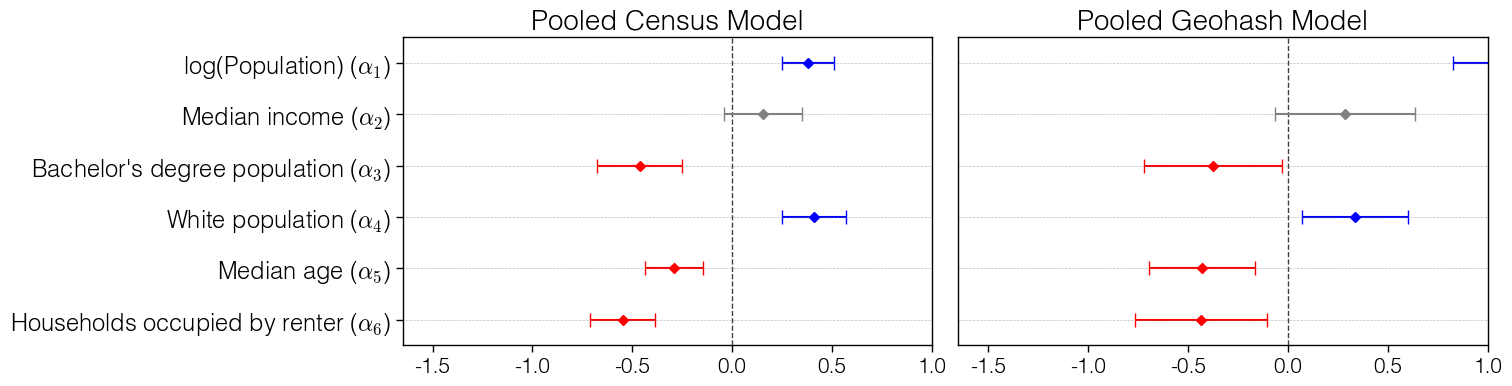

In [26]:
fig, Axes = plt.subplots(figsize=(14, 4), ncols=2)

for ax, unit in zip(Axes, ['census', 'geohash']):
    CI_df = pooled_df[(unit, 'multivariates')].loc['pooled']
    CI_df = CI_df.rename({'mean':'Estimate', '2.5%':'Lower bound', '97.5%':'Upper bound'},axis=1)

    #Plot on the corresponding axis:
    ax = vis.plot_CIs_covariates(CI_df[['Estimate', 'Lower bound', 'Upper bound']],
                                 show=False, ax=ax, ylabel_size=17, xlabel_size=15)

    if unit == 'census':
        _ = ax.set_yticks(ax.get_yticks()[::-1], [param_name(parameter.split('_')[-1]) for parameter in list(CI_df.index)])
    else:
        _ = ax.set_yticks([], [])
    _ = ax.set_title(f'Pooled {unit.capitalize()} Model', fontsize=20)
    _ = ax.set_xlim(-1.65, 1.)

_ = plt.subplots_adjust(wspace=0.05)
fig.savefig('../d07_plots/SI_pooled_multivariates_census_and_hash.pdf', pad_inches=0.3, bbox_inches='tight', format='pdf')
plt.show()

Finally, we look at the correlation between census tract and geohash inferred report rates

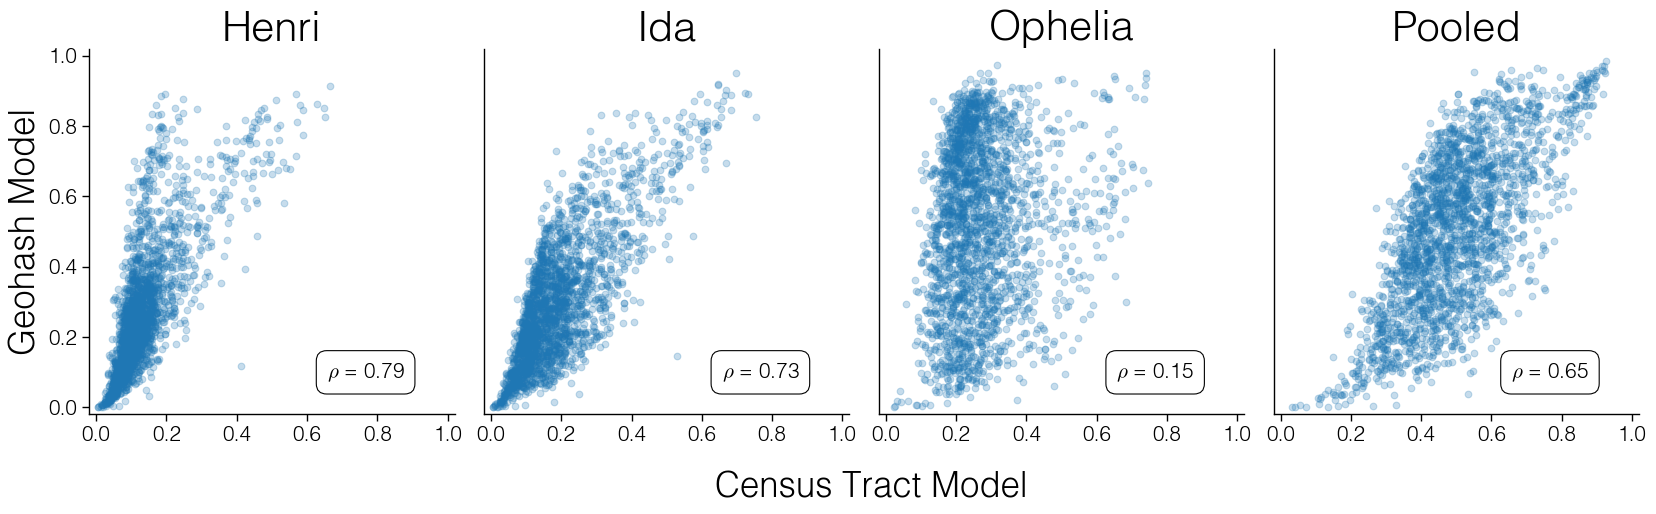

In [27]:
fig, Axes = plt.subplots(figsize=(20,5), ncols=4)

#Plot the results from the three indivudal storms:
for ax, storm in zip(Axes, ['henri', 'ida', 'ophelia']):

    #Get the alpha estimates:
    estimates_census = summary_df[('census',  storm)].loc[[f'alpha{k}' for k in range(7)], 'mean'].values
    estimates_hash   = summary_df[('geohash', storm)].loc[[f'alpha{k}' for k in range(7)], 'mean'].values

    #Plot psi:
    ax = vis.plot_psi_correlation(estimates_census, estimates_hash, features_census,
                                  ticks_y=True if storm=='henri' else False,
                                  title=storm.capitalize(),
                                  label_y='Geohash Model' if storm=='henri' else None,
                                  ax=ax)
#Plot the pooled result:
estimates_census = pooled_df[('census',  'multivariates')].loc['pooled', 'mean'].values
estimates_hash   = pooled_df[('geohash', 'multivariates')].loc['pooled', 'mean'].values
Axes[3] = vis.plot_psi_correlation(estimates_census, estimates_hash, features_census,
                                   intercept=False, ticks_y=False, title='Pooled', ax=Axes[3])

#Add one x-label as an annotation:
_ = plt.subplots_adjust(wspace=0.08)
_ = Axes[0].text(2.14, -.2, 'Census Tract Model', horizontalalignment='center', size=25,
                 verticalalignment='center', transform=Axes[0].transAxes)


fig.savefig('../d07_plots/SI_correlation_census_and_hash.pdf', pad_inches=0.3, bbox_inches='tight', format='pdf')
plt.show()

### SI Univariate Coefficients Analysis

We now turn to the univariate coefficients

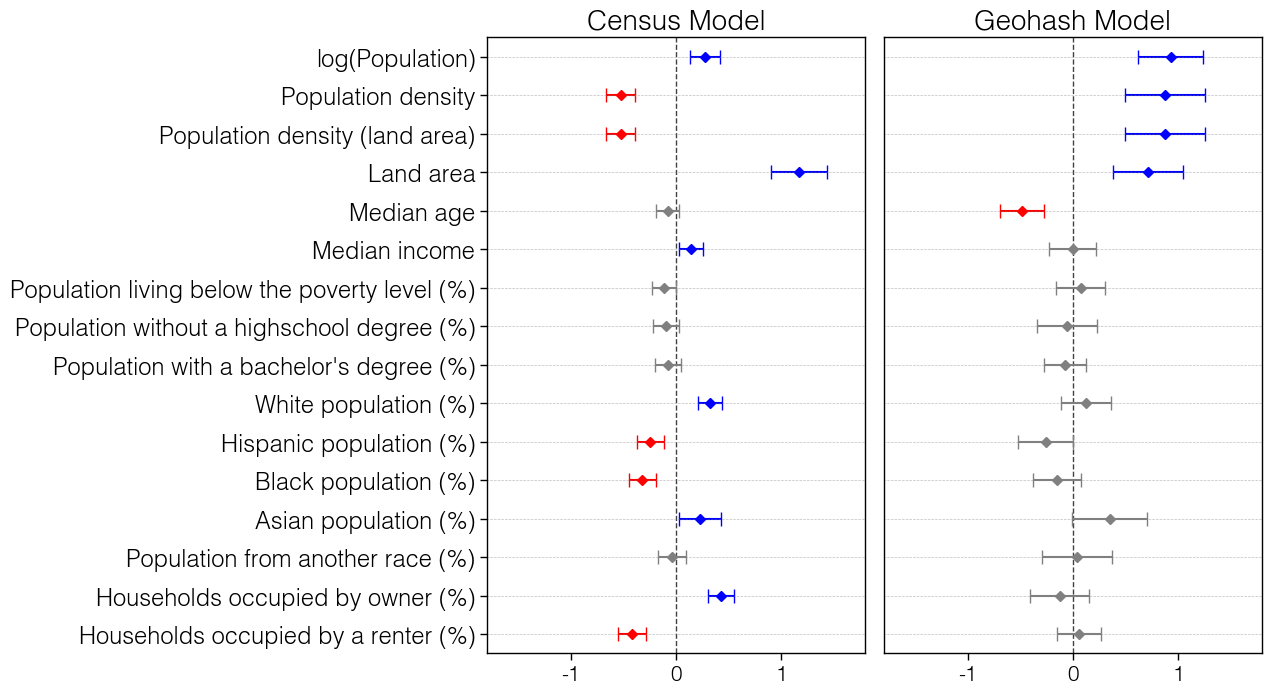

In [28]:
fig, Axes = plt.subplots(figsize=(10,8), ncols=2)

for ax, unit in zip(Axes,['census', 'geohash']):
    
    univariate_df = pooled_df[(unit,'univariates')].loc['pooled', ['mean', '2.5%', '97.5%']]
    univariate_df = univariate_df.rename({'mean':'Estimate', '2.5%':'Lower bound', '97.5%':'Upper bound'}, axis=1)
    univariate_df.index = univariate_df.index.map(vars._covariates_names)
    univariate_df = univariate_df.loc[[c for c in vars._covariates_names.values() if c in univariate_df.index]]

    ax = vis.plot_CIs_covariates(univariate_df, show=False, ax=ax, ylabel_size=17, xlabel_size=15)
    
    if unit=='geohash': _ = ax.set_yticks([])
    _ = ax.set_title(f'{unit.capitalize()} Model', size=20)
    _ = ax.set_xlim(-1.8, 1.8)

plt.subplots_adjust(wspace=0.05)

fig.savefig('../d07_plots/SI_univariates.pdf', pad_inches=0.3, bbox_inches='tight', format='pdf')
plt.show()

We show univariates for multiple storms:

census


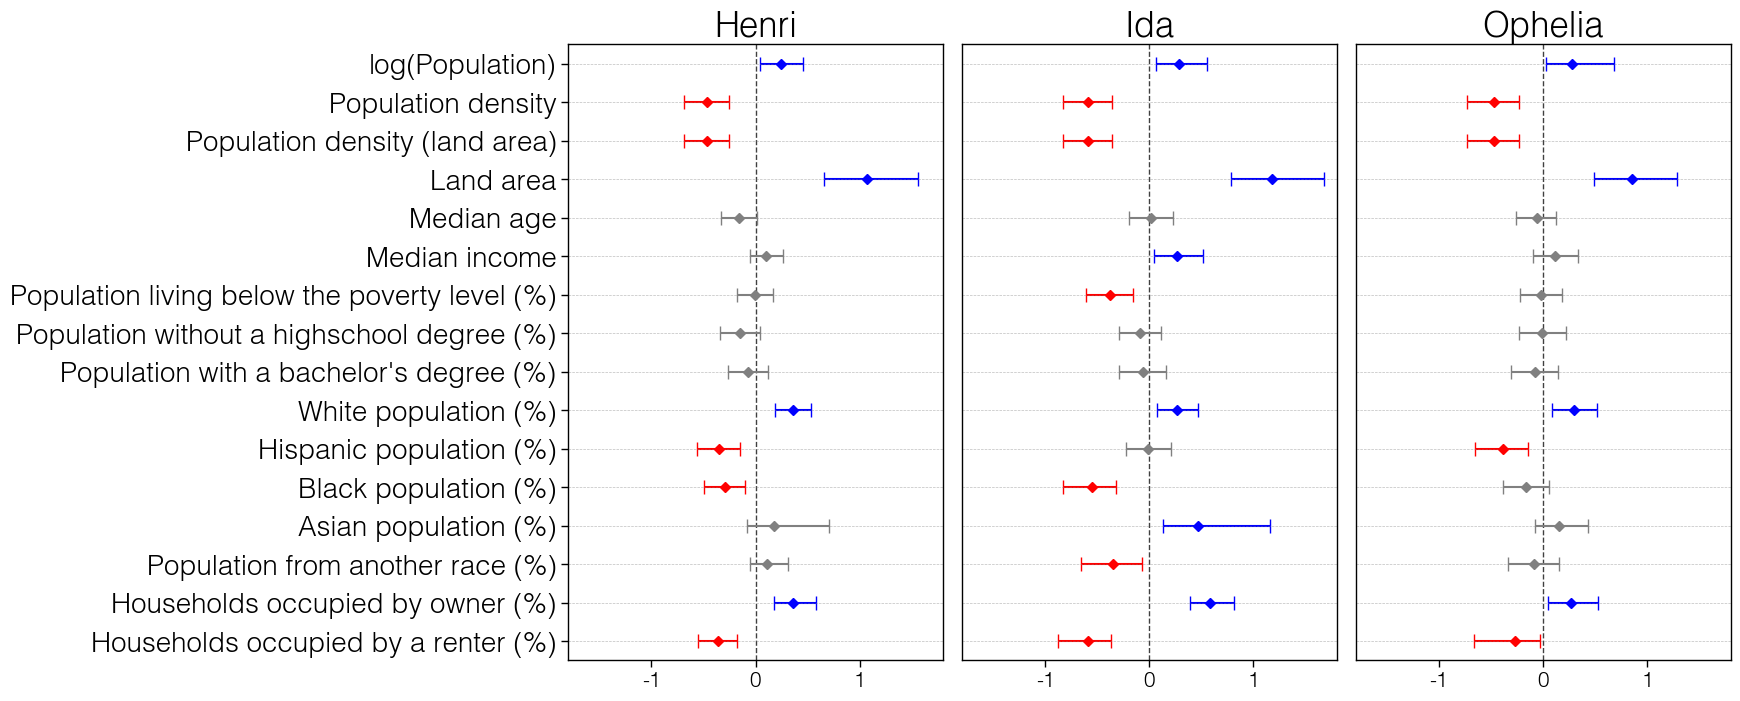

geohash


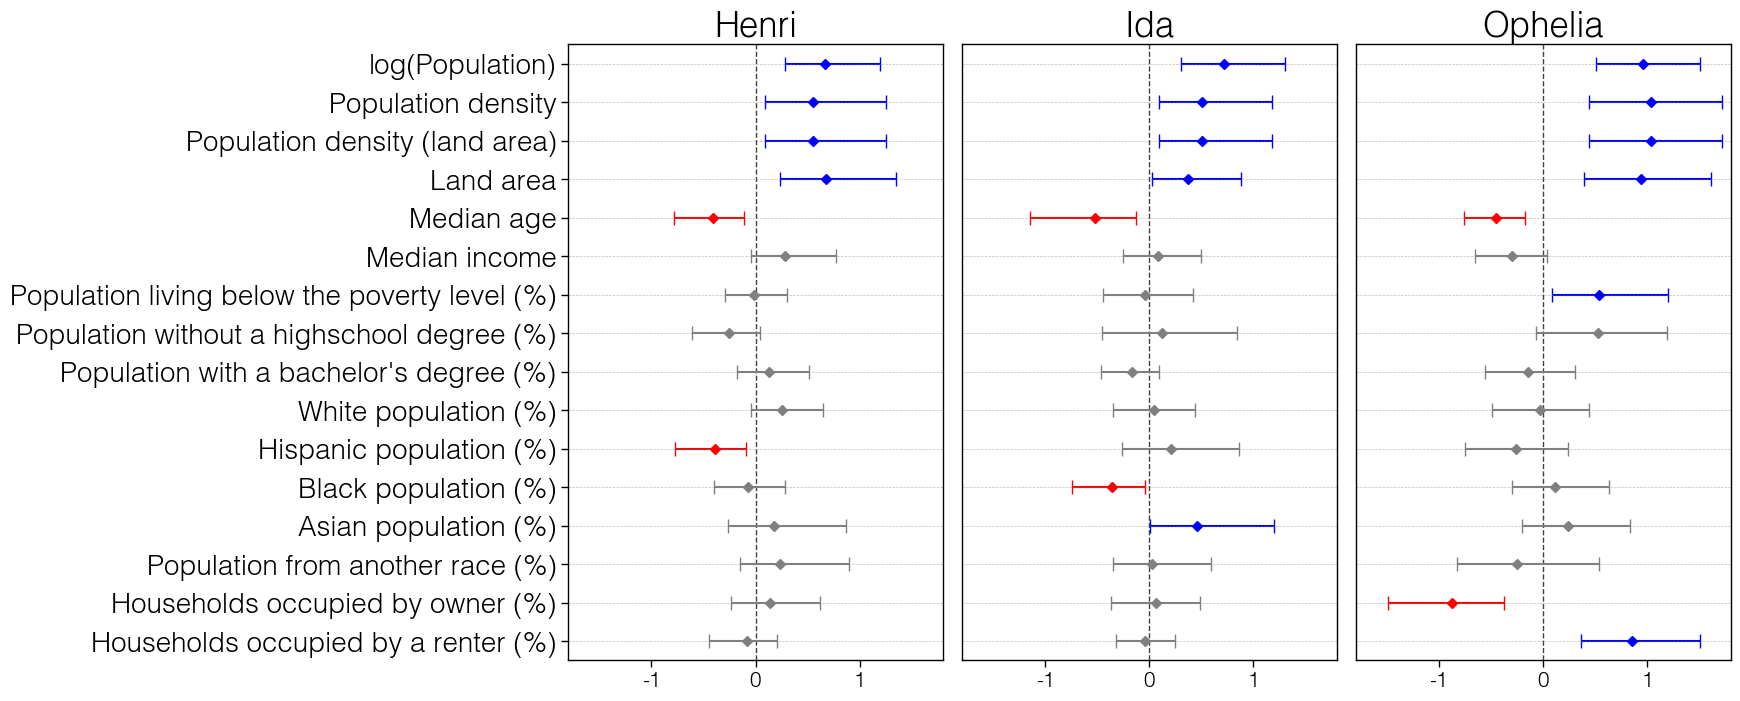

In [29]:
for unit in ['census', 'geohash']:
    print(unit)
    fig, Axes = plt.subplots(figsize=(15,8), ncols=3)

    for idx, storm in enumerate(['henri', 'ida', 'ophelia']):
        
        univariate_df = pooled_df[(unit, 'univariates')].loc[storm, ['mean', '2.5%', '97.5%']]
        univariate_df = univariate_df.rename({'mean':'Estimate', '2.5%':'Lower bound', '97.5%':'Upper bound'}, axis=1)
        univariate_df.index = univariate_df.index.map(vars._covariates_names)
        univariate_df = univariate_df.loc[[c for c in vars._covariates_names.values() if c in univariate_df.index]]
    
        Axes[idx] = vis.plot_CIs_covariates(univariate_df, show=False, ax=Axes[idx], ylabel_size=20, xlabel_size=15)
        

        #Configure the axis:
        _ = Axes[idx].set_title(storm.capitalize(), fontsize=25)
        if idx != 0: _ = Axes[idx].set_yticks([])
        _ = Axes[idx].set_xlim(-1.8, 1.8)
    
    _ = plt.subplots_adjust(wspace=0.05)
    fig.savefig(f'../d07_plots/SI_univariates_{unit}.pdf', pad_inches=0.3, bbox_inches='tight', format='pdf')
    plt.show()